In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", None, "display.max_columns", None)
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
import numpy as np

In [ ]:
tProductos = pd.read_csv('/content/drive/MyDrive/Reto IA Periodo2/Datos/tProducto.csv')
tVentas = pd.read_csv('/content/drive/MyDrive/Reto IA Periodo2/Datos/tVenta.csv')
tClientes = pd.read_csv('/content/drive/MyDrive/Reto IA Periodo2/Datos/tCliente.csv')
tVentasTest = pd.read_csv('/content/drive/MyDrive/Reto IA Periodo2/Datos/Test/tVentaTest.csv')
tProductosTest = pd.read_csv('/content/drive/MyDrive/Reto IA Periodo2/Datos/Test/tProductoTest.csv')

tMarcas = pd.read_csv('/content/drive/MyDrive/Reto IA Periodo2/Datos/Dimensiones/dimMarca.csv')
tDimensiones = pd.read_csv('/content/drive/MyDrive/Reto IA Periodo2/Datos/Dimensiones/dimContenedor.csv')
dimProductoCat = pd.read_csv('/content/drive/MyDrive/Reto IA Periodo2/Datos/Dimensiones/dimProductoCategoria.csv')
dimProductoTipo = pd.read_csv('/content/drive/MyDrive/Reto IA Periodo2/Datos/Dimensiones/dimProductoTipo.csv')
dimTamano = pd.read_csv('/content/drive/MyDrive/Reto IA Periodo2/Datos/Dimensiones/dimTamano.csv')

In [ ]:
def merge_cols(df, df_add, id):
  df = df.merge(df_add, on=id, how="inner")
  df.drop(columns=[id], axis = 1, inplace= True)
  return df

def prepare_products_df(products_df):
  return_df = products_df.copy()
  return_df = merge_cols(return_df, dimProductoCat, "iIdProductoCategoria")
  return_df = merge_cols(return_df, dimProductoTipo, "iIdProductoTipo")
  return_df = merge_cols(return_df, dimTamano, "iIdTamano")
  return_df = merge_cols(return_df, tDimensiones, "iIdContenedor")

  return return_df

In [ ]:
def group_places(df):
  places_col = ["parques", "supermercados", "hospitales", "preescolares", "primarias", "secundarias", "preparatorias", "universidades", "gimnasios"]
  total_sum = df[places_col].sum(axis=1)
  df.drop(columns=places_col, inplace=True)
  df["places"] = total_sum
  return df

In [ ]:
import joblib

drive_path = "/content/drive/MyDrive/Reto IA Periodo2/Modelos IA/Encoders/"

def embbed_col(df, col, embedding_dim=5):
    unique_categories = df[col].unique()
    category_to_index = {cat: idx for idx, cat in enumerate(unique_categories)}
    category_to_index["unknown"] = len(category_to_index)

    embedding_matrix = np.random.rand(len(unique_categories), embedding_dim)
    embeddings = df[col].map(category_to_index).apply(lambda idx: embedding_matrix[idx])
    embedding_cols = pd.DataFrame(
        embeddings.tolist(),
        columns=[f"{col}_emb_{i}" for i in range(embedding_dim)],
        index=df.index
    )

    joblib.dump(category_to_index, drive_path + f"{col}_category_to_index.pkl")
    joblib.dump(embedding_matrix, drive_path + f"{col}_embedding_matrix.pkl")

    df = pd.concat([df.drop(columns=[col]), embedding_cols], axis=1)
    return df

def one_hot_encode_col(df, col):
  encoder = OneHotEncoder(sparse_output=False)
  encoded_col = encoder.fit_transform(df[[col]])
  encoded_col_df = pd.DataFrame(encoded_col, columns=encoder.get_feature_names_out([col]))
  df = pd.concat([df.drop(columns=[col]), encoded_col_df], axis=1)
  return df

def embbed_df(df, embbed_dim = 5):
  cols = ["sProductoCategoria", "sProductoTipo", "sTamano", "sContenedor", "BrandGrouper", "GlobalFlavor"]
  for col in cols:
    df = embbed_col(df, col)
  cols_to_erase = ["iIdMarca", "iIdSabor", "iIdClusterProducto", "Material_desc", "BrandPresRet", "ProdKey",	"Presentation",	"MLSize",	"Pack",	"Ncb",	"SegAg",	"SegDet",	"GlobalCategory",	"GlobalSubcategory",	"dPrimeraVenta", "bViejo", "bExitoso"]
  df.drop(columns=cols_to_erase, axis = 1, inplace=True)
  return df

In [ ]:
mergedTProductos = prepare_products_df(tProductos)
mergedTProductos["test"] = 0

mergedTProductosTest = prepare_products_df(tProductosTest)
mergedTProductosTest["test"] = 1

mergedTProductos = pd.concat([mergedTProductos, mergedTProductosTest]).reset_index(drop=True)

t_productos = embbed_df(mergedTProductos, 3)

In [ ]:
t_productos.head()

Material  Productos_Por_Empaque  bReturnability  test  \
0      9465                      6               0     0   
1     14450                      6               0     0   
2      1088                      4               0     0   
3      2142                      6               0     0   
4       623                     12               0     0   

   sProductoCategoria_emb_0  sProductoCategoria_emb_1  \
0                  0.890925                  0.133742   
1                  0.773051                  0.316902   
2                  0.890925                  0.133742   
3                  0.890925                  0.133742   
4                  0.752088                  0.991011   

   sProductoCategoria_emb_2  sProductoCategoria_emb_3  \
0                  0.040683                  0.475708   
1                  0.000571                  0.082739   
2                  0.040683                  0.475708   
3                  0.040683                  0.475708   
4                  0.138148                  0.164377   

   sProductoCategoria_emb_4  sProductoTipo_emb_0  sProductoTipo_emb_1  \
0                  0.664245             0.843522             0.512734   
1                  0.694319             0.637140             0.440395   
2                  0.664245             0.218620             0.225549   
3                  0.664245             0.120044             0.385771   
4                  0.427237             0.230855             0.747100   

   sProductoTipo_emb_2  sProductoTipo_emb_3  sProductoTipo_emb_4  \
0             0.425707             0.195181             0.685712   
1             0.782369             0.925801             0.825918   
2             0.276458             0.793363             0.678725   
3             0.876471             0.642995             0.084973   
4             0.545268             0.692777             0.290101   

   sTamano_emb_0  sTamano_emb_1  sTamano_emb_2  sTamano_emb_3  sTamano_emb_4  \
0       0.351148       0.750329       0.257198       0.541721       0.899878   
1       0.351148       0.750329       0.257198       0.541721       0.899878   
2       0.745737       0.106678       0.672671       0.446349       0.828772   
3       0.351148       0.750329       0.257198       0.541721       0.899878   
4       0.351148       0.750329       0.257198       0.541721       0.899878   

   sContenedor_emb_0  sContenedor_emb_1  sContenedor_emb_2  sContenedor_emb_3  \
0           0.648419           0.575326           0.657795           0.882394   
1           0.648419           0.575326           0.657795           0.882394   
2           0.648419           0.575326           0.657795           0.882394   
3           0.482557           0.998686           0.287831           0.458091   
4           0.613870           0.291244           0.493804           0.939088   

   sContenedor_emb_4  BrandGrouper_emb_0  BrandGrouper_emb_1  \
0           0.110418            0.704164            0.870747   
1           0.110418            0.175045            0.053053   
2           0.110418            0.898677            0.925965   
3           0.388306            0.617574            0.217221   
4           0.866518            0.760779            0.377956   

   BrandGrouper_emb_2  BrandGrouper_emb_3  BrandGrouper_emb_4  \
0            0.093467            0.854092            0.716620   
1            0.792574            0.341706            0.051344   
2            0.419225            0.381786            0.793929   
3            0.795348            0.585596            0.630855   
4            0.484280            0.977055            0.377889   

   GlobalFlavor_emb_0  GlobalFlavor_emb_1  GlobalFlavor_emb_2  \
0            0.113382            0.349194            0.648009   
1            0.079229            0.527978            0.925691   
2            0.065401            0.343628            0.527353   
3            0.065401            0.343628            0.527353   
4            0.361974            0.0621

In [ ]:
tVentasAll = pd.concat([tVentas, tVentasTest]).reset_index(drop=True)

# drop half of tVentasAll
tVentasAll = tVentasAll.sample(frac=0.6, random_state=42)

tVentasAll["calmonth"] = tVentasAll["calmonth"].apply(lambda x: x.split("-")[1])

tVentasPerMonthPerProduct = (
    tVentasAll
    .groupby(["CustomerId", "Material", "calmonth"], as_index=False)["uni_box"]
    .mean()
    .rename(columns={"uni_box": "uni_box_media_month"})
)

# Merge of products with all sales
tVentasPerMonthPerProductWithProducts = tVentasPerMonthPerProduct.merge(t_productos, on="Material", how="inner").drop(columns=["Material"], axis = 1)
tVentasPerMonthPerProductWithProducts = tVentasPerMonthPerProductWithProducts.sort_values('calmonth')
tVentasPerMonthPerProductWithProducts = one_hot_encode_col(tVentasPerMonthPerProductWithProducts, "calmonth")
tVentasPerMonthPerProductWithProducts.head()

CustomerId  uni_box_media_month  Productos_Por_Empaque  \
260040   500142741             0.845400                      6   
237543   500125174             1.276533                      6   
601399   500424906             1.324400                     24   
805986   510464967             0.563600                      8   
601398   500424906             0.250400                      6   

        bReturnability  test  sProductoCategoria_emb_0  \
260040               0     0                  0.966188   
237543               0     0                  0.966188   
601399               0     0                  0.752088   
805986               0     0                  0.690976   
601398               0     0                  0.966188   

        sProductoCategoria_emb_1  sProductoCategoria_emb_2  \
260040                  0.370018                  0.809252   
237543                  0.370018                  0.809252   
601399                  0.991011                  0.138148   
805986                  0.014327                  0.832761   
601398                  0.370018                  0.809252   

        sProductoCategoria_emb_3  sProductoCategoria_emb_4  \
260040                  0.307134                  0.684962   
237543                  0.307134                  0.684962   
601399                  0.164377                  0.427237   
805986                  0.774979                  0.441990   
601398                  0.307134                  0.684962   

        sProductoTipo_emb_0  sProductoTipo_emb_1  sProductoTipo_emb_2  \
260040             0.257567             0.543673             0.892332   
237543             0.525552             0.848115             0.969277   
601399             0.230855             0.747100             0.545268   
805986             0.718589             0.669924             0.840900   
601398             0.525552             0.848115             0.969277   

        sProductoTipo_emb_3  sProductoTipo_emb_4  sTamano_emb_0  \
260040             0.683185             0.585897       0.351148   
237543             0.919116             0.437916       0.351148   
601399             0.692777             0.290101       0.351148   
805986             0.293772             0.844017       0.351148   
601398             0.919116             0.437916       0.351148   

        sTamano_emb_1  sTamano_emb_2  sTamano_emb_3  sTamano_emb_4  \
260040       0.750329       0.257198       0.541721       0.899878   
237543       0.750329       0.257198       0.541721       0.899878   
601399       0.750329       0.257198       0.541721       0.899878   
805986       0.750329       0.257198       0.541721       0.899878   
601398       0.750329       0.257198       0.541721       0.899878   

        sContenedor_emb_0  sContenedor_emb_1  sContenedor_emb_2  \
260040           0.648419           0.575326           0.657795   
237543           0.613870           0.291244           0.493804   
601399           0.482557           0.998686           0.287831   
805986           0.708820           0.883121           0.131655   
601398           0.648419           0.575326           0.657795   

        sContenedor_emb_3  sContenedor_emb_4  BrandGrouper_emb_0  \
260040           0.882394           0.110418            0.569415   
237543           0.939088           0.866518            0.569415   
601399           0.458091           0.388306            0.760779   
805986           0.004426           0.604398            0.527416   
601398           0.882394           0.110418            0.569415   

        BrandGrouper_emb_1  BrandGrouper_emb_2  BrandGrouper_emb_3  \
260040            0.468635            0.901946            0.707366   
237543            0.468635            0.901946            0.707366   
601399            0.377956            0.484280            0.977055   
805986            0.919238            0.492671            0.702942   
601398            0.468635            0.901946            0.707366   

        BrandGrouper

In [ ]:
tVentasPerMonthPerProductWithProductsTrain = tVentasPerMonthPerProductWithProducts[tVentasPerMonthPerProductWithProducts["test"] == 0].drop(columns=["test"]).reset_index(drop=True)
tVentasPerMonthPerProductWithProductsTest = tVentasPerMonthPerProductWithProducts[tVentasPerMonthPerProductWithProducts["test"] == 1].drop(columns=["test"]).reset_index(drop=True)

tVentasPerMonthPerProductWithProductsAndClientsTrain = tVentasPerMonthPerProductWithProductsTrain.merge(tClientes, on=["CustomerId"], how="inner").drop(columns=["CustomerId"], axis=1)
tVentasPerMonthPerProductWithProductsAndClientsTest = tVentasPerMonthPerProductWithProductsTest.merge(tClientes, on=["CustomerId"], how="inner").drop(columns=["CustomerId"], axis=1)

In [ ]:
cols_to_erase = ["socioeconomic_status_rgm", "rgm_channel", "POBTOT_300m", "iIdZona", "industry_customer_size", "iIdSubCanal", "iIdClusterCliente", "iIdSubClusterCliente", "iIdNivelSocieconomico", "prob_VPH_TV_300m"]
tVentasPerMonthPerProductWithProductsAndClientsTrain.drop(columns=cols_to_erase, inplace=True)
tVentasPerMonthPerProductWithProductsAndClientsTest.drop(columns=cols_to_erase, inplace=True)

In [ ]:
tVentasPerMonthPerProductWithProductsAndClientsTrain.head()

uni_box_media_month  Productos_Por_Empaque  bReturnability  \
0             0.845400                      6               0   
1             1.276533                      6               0   
2             1.324400                     24               0   
3             0.250400                      6               0   
4             0.478700                      6               0   

   sProductoCategoria_emb_0  sProductoCategoria_emb_1  \
0                  0.966188                  0.370018   
1                  0.966188                  0.370018   
2                  0.752088                  0.991011   
3                  0.966188                  0.370018   
4                  0.966188                  0.370018   

   sProductoCategoria_emb_2  sProductoCategoria_emb_3  \
0                  0.809252                  0.307134   
1                  0.809252                  0.307134   
2                  0.138148                  0.164377   
3                  0.809252                  0.307134   
4                  0.809252                  0.307134   

   sProductoCategoria_emb_4  sProductoTipo_emb_0  sProductoTipo_emb_1  \
0                  0.684962             0.257567             0.543673   
1                  0.684962             0.525552             0.848115   
2                  0.427237             0.230855             0.747100   
3                  0.684962             0.525552             0.848115   
4                  0.684962             0.525552             0.848115   

   sProductoTipo_emb_2  sProductoTipo_emb_3  sProductoTipo_emb_4  \
0             0.892332             0.683185             0.585897   
1             0.969277             0.919116             0.437916   
2             0.545268             0.692777             0.290101   
3             0.969277             0.919116             0.437916   
4             0.969277             0.919116             0.437916   

   sTamano_emb_0  sTamano_emb_1  sTamano_emb_2  sTamano_emb_3  sTamano_emb_4  \
0       0.351148       0.750329       0.257198       0.541721       0.899878   
1       0.351148       0.750329       0.257198       0.541721       0.899878   
2       0.351148       0.750329       0.257198       0.541721       0.899878   
3       0.351148       0.750329       0.257198       0.541721       0.899878   
4       0.351148       0.750329       0.257198       0.541721       0.899878   

   sContenedor_emb_0  sContenedor_emb_1  sContenedor_emb_2  sContenedor_emb_3  \
0           0.648419           0.575326           0.657795           0.882394   
1           0.613870           0.291244           0.493804           0.939088   
2           0.482557           0.998686           0.287831           0.458091   
3           0.648419           0.575326           0.657795           0.882394   
4           0.613870           0.291244           0.493804           0.939088   

   sContenedor_emb_4  BrandGrouper_emb_0  BrandGrouper_emb_1  \
0           0.110418            0.569415            0.468635   
1           0.866518            0.569415            0.468635   
2           0.388306            0.760779            0.377956   
3           0.110418            0.569415            0.468635   
4           0.866518            0.569415            0.468635   

   BrandGrouper_emb_2  BrandGrouper_emb_3  BrandGrouper_emb_4  \
0            0.901946            0.707366            0.486452   
1            0.901946            0.707366            0.486452   
2            0.484280            0.977055            0.377889   
3            0.901946            0.707366            0.486452   
4            0.901946            0.707366            0.486452   

   GlobalFlavor_emb_0  GlobalFlavor_emb_1  GlobalFlavor_emb_2  \
0            0.218898            0.763223            0.106634   
1            0.824861            0.187230            0.366815   
2            0.361974            0.062144            0.724859   
3            0.690281            0.840167            0.089243   
4        

In [ ]:
def turn_data_into_sequences(df, sequence_length):
  data_array = df.drop(columns=["uni_box_media_month"]).values
  output_array = df["uni_box_media_month"].values

  X, y = [], []
  for i in range(len(data_array) - sequence_length):
    X.append(data_array[i:i+sequence_length])
    y.append(output_array[i+sequence_length])
  return np.array(X), np.array(y)

In [ ]:
tVentasPerMonthPerProductWithProductsAndClientsTrain.head(1)

uni_box_media_month  Productos_Por_Empaque  bReturnability  \
0               0.8454                      6               0   

   sProductoCategoria_emb_0  sProductoCategoria_emb_1  \
0                  0.966188                  0.370018   

   sProductoCategoria_emb_2  sProductoCategoria_emb_3  \
0                  0.809252                  0.307134   

   sProductoCategoria_emb_4  sProductoTipo_emb_0  sProductoTipo_emb_1  \
0                  0.684962             0.257567             0.543673   

   sProductoTipo_emb_2  sProductoTipo_emb_3  sProductoTipo_emb_4  \
0             0.892332             0.683185             0.585897   

   sTamano_emb_0  sTamano_emb_1  sTamano_emb_2  sTamano_emb_3  sTamano_emb_4  \
0       0.351148       0.750329       0.257198       0.541721       0.899878   

   sContenedor_emb_0  sContenedor_emb_1  sContenedor_emb_2  sContenedor_emb_3  \
0           0.648419           0.575326           0.657795           0.882394   

   sContenedor_emb_4  BrandGrouper_emb_0  BrandGrouper_emb_1  \
0           0.110418            0.569415            0.468635   

   BrandGrouper_emb_2  BrandGrouper_emb_3  BrandGrouper_emb_4  \
0            0.901946            0.707366            0.486452   

   GlobalFlavor_emb_0  GlobalFlavor_emb_1  GlobalFlavor_emb_2  \
0            0.218898            0.763223            0.106634   

   GlobalFlavor_emb_3  GlobalFlavor_emb_4  calmonth_01  calmonth_02  \
0            0.924584            0.359797          0.0          0.0   

   calmonth_03  calmonth_04  calmonth_05  calmonth_06  calmonth_07  \
0          0.0          1.0          0.0          0.0          0.0   

   calmonth_08  calmonth_09  calmonth_10  calmonth_11  calmonth_12  \
0          0.0          0.0          0.0          0.0          0.0   

   Peso_manza  parques  supermercados  hospitales  preescolares  primarias  \
0        0.68      2.0            0.0         0.0           1.0        1.0   

   secundarias  preparatorias  universidades  gimnasios  \
0          0.0            0.0            0.0        0.0   

   pea_conteo_personas_300m  pnea_conteo_personas_300m  arboles_300m  \
0                379.900952                  281.21459          52.0   

   banqueta_300m  prob_inter_mod_300m  viviendas_300m  accesibilidad  
0           60.0             0.458331      244.735459       0.166046

In [ ]:
x_train = tVentasPerMonthPerProductWithProductsAndClientsTrain.drop(columns=["uni_box_media_month"])
x_test = tVentasPerMonthPerProductWithProductsAndClientsTest.drop(columns=["uni_box_media_month"])

y_train = tVentasPerMonthPerProductWithProductsAndClientsTrain.uni_box_media_month
y_test = tVentasPerMonthPerProductWithProductsAndClientsTest.uni_box_media_month

y_train = tf.reshape(y_train, (-1, 1))
y_test = tf.reshape(y_test, (-1, 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
4435/4435 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 6.3574 - mae: 6.7422 - mse: 2077.8643 - val_loss: 5.5833 - val_mae: 5.9515 - val_mse: 1395.2368 - learning_rate: 1.0000e-05
Epoch 2/30
4435/4435 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 5.9126 - mae: 6.2959 - mse: 1428.2432 - val_loss: 5.4245 - val_mae: 5.8107 - val_mse: 1391.0955 - learning_rate: 1.0000e-05
Epoch 3/30
4435/4435 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 5.7718 - mae: 6.1689 - mse: 1716.2660 - val_loss: 5.3403 - val_mae: 5.7449 - val_mse: 1387.8496 - learning_rate: 1.0000e-05
Epoch 4/30
4435/4435 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 5.7258 - mae: 6.1353 - mse: 1723.1724 - val_loss: 5.2972 - val_mae: 5.7122 - val_mse: 1385.6552 - learning_rate: 1.0000e-05
Epoch 5/30
4435/4435 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 5.6963 - mae: 6.1148 - mse: 1813.0244 - val_loss: 5.2757 - val_mae: 5.6970 - val_mse: 1384.4579 - learning_rate: 1.0000e-05
Epoch 6/30
4435/4435 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 5.

y_test    y_pred
0    9.510400  1.981288
1    0.528400  1.856377
2    0.528400  1.966314
3    0.375100  1.914305
4   47.552000  2.033613
5   14.265600  1.824761
6    9.510400  1.840721
7    0.375100  1.869422
8    0.375100  1.139479
9    0.750200  1.809738
10  -0.105878  1.823558
11   0.375100  1.875415
12   0.375100  1.785216
13   0.528400  1.915564
14   4.755200  1.789441
15   0.375100  1.778415
16   0.528400  1.967650
17   2.377500  2.024654
18   9.510400  1.788069
19   4.755200  1.773525

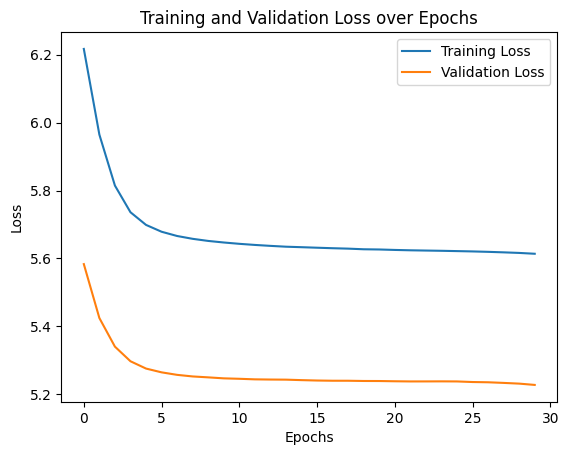

In [ ]:
with tf.device('/device:GPU:0'):
  model = Sequential()
  model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(8, activation='relu'))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(4, activation='relu'))
  model.add(Dense(1))

  _epochs = 30

  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

  model.compile(optimizer=Adam(learning_rate=0.00001),loss="huber", metrics=["mae", "mse"])

  history = model.fit(x_train, y_train, epochs=_epochs, batch_size=128, validation_split=0.3, verbose = True, callbacks=[early_stopping, reduce_lr])

# Your code here
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')

y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

y_test_np = y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test
y_pred_np = y_pred if isinstance(y_pred, np.ndarray) else y_pred.numpy()

results = pd.DataFrame({"y_test": y_test_np.flatten(), "y_pred": y_pred_np.flatten()})
results.head(20)

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 32)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,189 (28.09 KB)

 Trainable params: 2,369 (9.25 KB)

 Non-trainable params: 80 (320.00 B)

 Optimizer params: 4,740 (18.52 KB)

In [ ]:
''' x_train = tVentasPerMonthPerProductWithProductsAndClientsTrain.drop(columns=["uni_box_media_month"])
x_test = tVentasPerMonthPerProductWithProductsAndClientsTest.drop(columns=["uni_box_media_month"])

y_train = tVentasPerMonthPerProductWithProductsAndClientsTrain.uni_box_media_month
y_test = tVentasPerMonthPerProductWithProductsAndClientsTest.uni_box_media_month

y_train = tf.reshape(y_train, (-1, 1))
y_test = tf.reshape(y_test, (-1, 1)) '''

x_train, y_train = turn_data_into_sequences(tVentasPerMonthPerProductWithProductsAndClientsTrain, 6)
x_test, y_test = turn_data_into_sequences(tVentasPerMonthPerProductWithProductsAndClientsTest, 6)

In [ ]:
x_train.shape

(810902, 12, 61)

In [ ]:
x_test.shape

(1338, 12, 61)

In [ ]:
print(x_train.shape)

(810908, 6, 61)


In [ ]:
def model_builder(hp):
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(1))

  learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
  batch_size = hp.Choice('batch_size', values=[64, 128, 256])

  optimizer = Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,loss="huber", metrics=["mae", "mse"])

  return model

In [ ]:
''' %pip install keras-tuner
import keras_tuner as kt '''

' %pip install keras-tuner\nimport keras_tuner as kt '

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Is TensorFlow using GPU? ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Num GPUs Available:  1
Is TensorFlow using GPU?  True


In [ ]:
''' from keras_tuner.tuners import BayesianOptimization

tuner = BayesianOptimization(
    hypermodel=model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    num_initial_points=2,
)
'''
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

### Best params found for a val_loss of 4.5455
### lr: 2.8791903145831775e-05
### batch_size: 64

In [ ]:
''' with tf.device('/GPU:0'):
  tuner.search(x_train, y_train, epochs=20, validation_split=0.30, verbose=True, callbacks=[early_stopping, reduce_lr])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best lr:', best_hps.get('learning_rate'))
print('Best batch size:', best_hps.get('batch_size'))

model = tuner.hypermodel.build(best_hps)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
 '''

" with tf.device('/GPU:0'):\n  tuner.search(x_train, y_train, epochs=20, validation_split=0.30, verbose=True, callbacks=[early_stopping, reduce_lr])\n\nbest_hps = tuner.get_best_hyperparameters(num_trials=1)[0]\nprint('Best lr:', best_hps.get('learning_rate'))\nprint('Best batch size:', best_hps.get('batch_size'))\n\nmodel = tuner.hypermodel.build(best_hps)\nbest_hps = tuner.get_best_hyperparameters(num_trials=1)[0]\nmodel = tuner.hypermodel.build(best_hps)\n "

In [ ]:
x_train.shape

(810908, 6, 61)

In [ ]:
x_test.shape

(1344, 6, 61)

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), kernel_regularizer=regularizers.l2(0.001), return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(16, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 64)              │          32,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 12, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 12, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,721 (221.57 KB)

 Trainable params: 56,433 (220.44 KB)

 Non-trainable params: 288 (1.12 KB)

In [ ]:
optimizer = Adam(learning_rate=2.8791903145831775e-05)

model.compile(optimizer=optimizer,loss="huber", metrics=["mae", "mse"])

In [ ]:
with tf.device('/GPU:0'):
  history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.30, verbose=True, callbacks=[early_stopping, reduce_lr])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Reto IA Periodo2/Modelos IA/customer-sales-prediction.keras')
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

y_test_np = y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test
y_pred_np = y_pred if isinstance(y_pred, np.ndarray) else y_pred.numpy()

results = pd.DataFrame({"y_test": y_test_np.flatten(), "y_pred": y_pred_np.flatten()})

42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Mean Squared Error: 15.281987325718026


In [ ]:
results.head()

y_test    y_pred
0  9.510400  1.899702
1  0.375100  1.907443
2  0.375100  1.918057
3  0.750200  1.903096
4 -0.105878  1.897800

In [ ]:
model.save("customer-sales-prediction.keras")